In [1]:

import numpy             as np
import matplotlib.pyplot as plt
import glob
import h5py as h
%matplotlib inline

In [2]:
def Hist2d(title,Energys,Times,binss,xlimit,ylimit):
    fig,ax = plt.subplots(figsize=(8,8))
    plt.hist2d(Energys,Times,bins=binss,cmap=plt.cm.BuGn_r)
    plt.title(title)

    plt.ylabel("Energy keV",fontsize=26)
    plt.xlabel("Time us",fontsize=26)
    plt.tick_params('both', length=10, width=2, which='major')
    plt.tick_params('both', length=5, width=1, which='minor')
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.xlim(xlimit)
    plt.ylim(ylimit)
    plt.grid(True)
    plt.tight_layout()

    plt.savefig('/home/ilker/Dropbox/nexus/build/source/'+title + '.png')
    plt.show()
    
def Hist1d(title,Energys,Bins,xlimit,ylimit,limits=False):
    fig, ax = plt.subplots(figsize=(8,8))
    plt.hist(Energys,bins=Bins,alpha=0.7,label=title)
    plt.ylabel("Counts",fontsize=26)
    plt.xlabel("Energy keV",fontsize=26)
    plt.tick_params('both', length=10, width=2, which='major')
    plt.tick_params('both', length=5, width=1, which='minor')
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.legend(loc='upper right',fontsize=24,shadow=True, fancybox=True)
    plt.semilogy()
    if(limits):
        plt.xlim(xlimit)
        plt.ylim(ylimit)
    plt.grid(True)
    plt.tight_layout()

    #plt.savefig('/Users/austinmcdonald/Desktop/'+title + '.png')
    plt.show()
def Plot2d(title,x,y):
    fig,ax = plt.subplots(figsize=(8,8))
    plt.plot(x,y)
    plt.title(title)
    plt.ylabel("Z mm",fontsize=26)
    plt.xlabel("Y mm",fontsize=26)
    plt.tick_params('both', length=10, width=2, which='major')
    plt.tick_params('both', length=5, width=1, which='minor')
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.grid(True)
    plt.tight_layout()
    plt.show()    

In [3]:
def getEnergys(file):
    data = h.File(file,'r') 
    #data['MC']['Con']
    Energys = []
    for x in range(0,10000):
        Current_Event = x
        Current_Hit_Mask = data["MC"]['hits']['event_id'] == Current_Event

        Current_Particle_Mask = data["MC"]['particles']['event_id'] == Current_Event

        Electron_Mask = data["MC"]['particles'][Current_Particle_Mask]['particle_name'] == b'e-'

        Electron_PIDS = data["MC"]['particles'][Current_Particle_Mask][Electron_Mask]['particle_id']

        A = data["MC"]['hits'][Current_Hit_Mask]['particle_id'] 
        Hit_Electron_Maks = np.in1d(A, Electron_PIDS)

        Energys.append(data["MC"]['hits'][Current_Hit_Mask][Hit_Electron_Maks]['energy'].sum()*1e3)
    Energys = np.array(Energys)
    return Energys

def getTracks(file,Current_Event=0):
    data = h.File(file,'r')     

    Current_Hit_Mask = data["MC"]['hits']['event_id'] == Current_Event

    Current_Particle_Mask = data["MC"]['particles']['event_id'] == Current_Event

    Electron_Mask = data["MC"]['particles'][Current_Particle_Mask]['particle_name'] == b'e-'

    Electron_PIDS = data["MC"]['particles'][Current_Particle_Mask][Electron_Mask]['particle_id']

    A = data["MC"]['hits'][Current_Hit_Mask]['particle_id'] 
    Hit_Electron_Maks = np.in1d(A, Electron_PIDS)
    ElectronData=data["MC"]['hits'][Current_Hit_Mask][Hit_Electron_Maks]
    PIDWithCounts={}

    for i in ElectronData["particle_id"]:
        PID_mask=ElectronData["particle_id"]==i
        count = np.count_nonzero(PID_mask)
        PIDWithCounts[count]=PID_mask

    max_key=max(list(PIDWithCounts.keys()))
    ElectronsWithMaxTrack=ElectronData[PIDWithCounts[max_key]]
    Tracks=np.array([ElectronsWithMaxTrack["x"],ElectronsWithMaxTrack["y"],ElectronsWithMaxTrack["z"]])

    return Tracks

In [ ]:
file = "/home/ilker/Dropbox/nexus/build/source/Cs137_2mm_1.h5"
E=getEnergys(file)

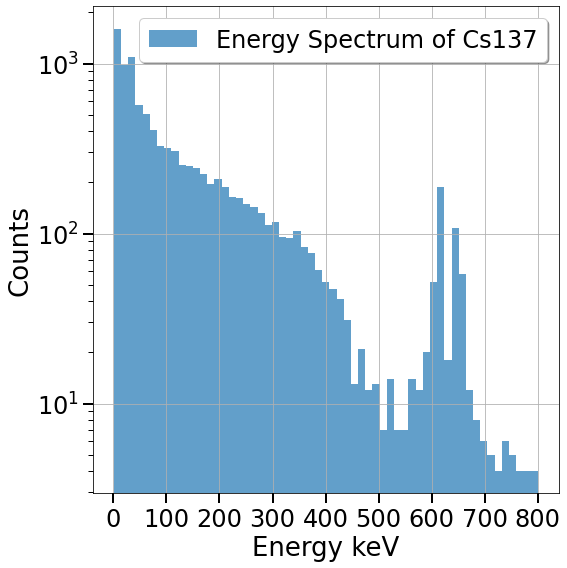

10000


In [5]:
Hist1d('Energy Spectrum of Cs137',E,np.linspace(1,800,60),0,0)
print(len(E))

In [6]:
file="/home/ilker/Dropbox/nexus/build/source/Ba133_2mm.h5"
BaE=getEnergys(file)

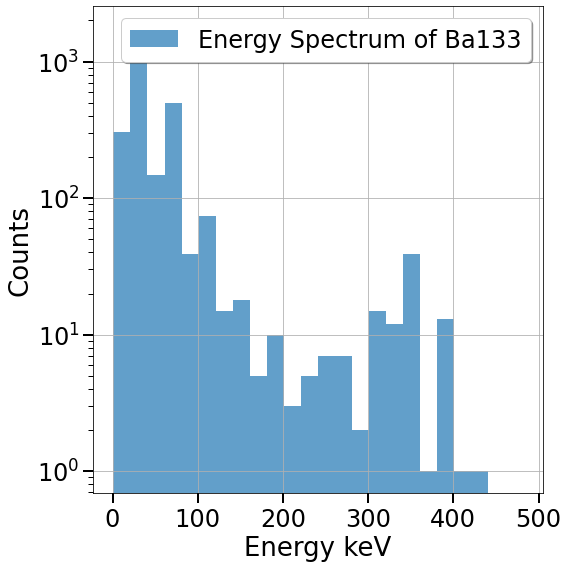

10000


In [7]:
Hist1d('Energy Spectrum of Ba133',BaE,np.arange(1,500,20),0,0)
print(len(BaE))

In [8]:
file="/home/ilker/Dropbox/nexus/build/source/Ba133_13us_5mm.h5"
BaE2=getEnergys(file)

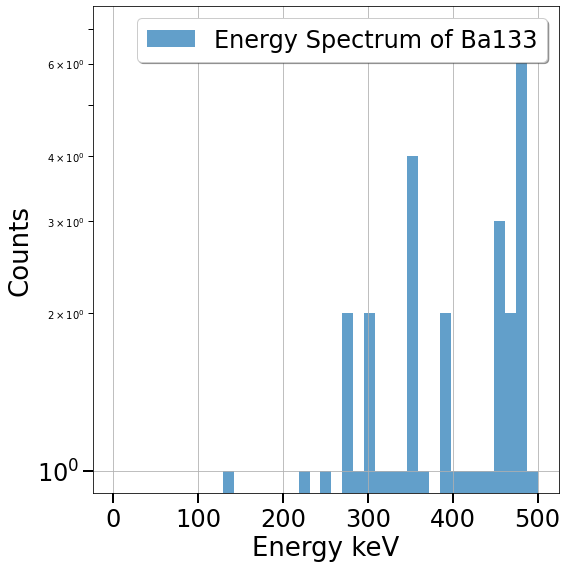

In [9]:
Hist1d('Energy Spectrum of Ba133',BaE2,np.linspace(1,500,40),0,0)

In [17]:
A=getTracks("/home/ilker/Dropbox/nexus/build/source/Ba133_2mm.h5",2)

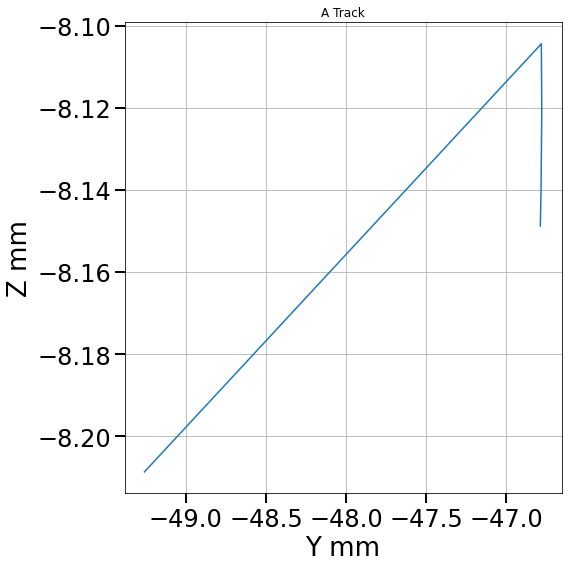

In [18]:
Plot2d("A Track",A[2],A[1])

In [22]:
file = "/home/ilker/Dropbox/nexus/build/source/gamma31_2mm_10k.h5"
Egama1=getEnergys(file)

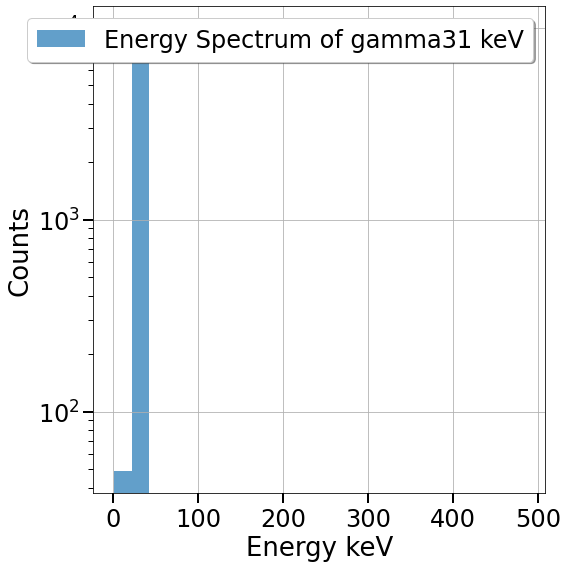

In [38]:
Hist1d('Energy Spectrum of gamma31 keV',Egama1,np.arange(1,500,21),0,0)

In [24]:
file = "/home/ilker/Dropbox/nexus/build/source/gamma61_2mm_10k.h5"
Egama2=getEnergys(file)

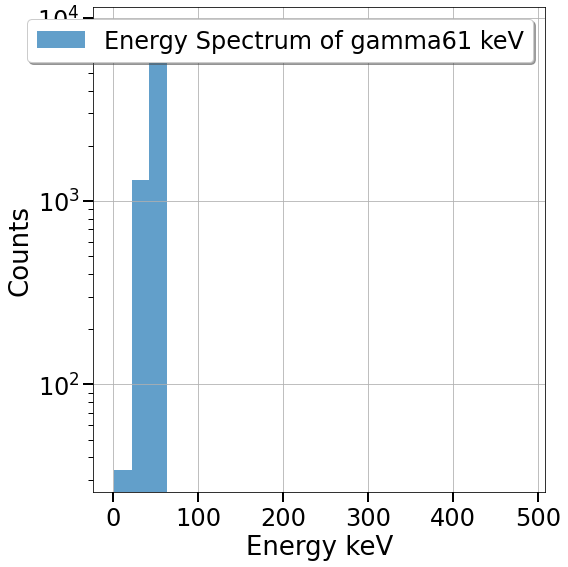

In [37]:
Hist1d('Energy Spectrum of gamma61 keV',Egama2,np.arange(1,500,21),0,0)